The model is built on Kannada MNIST dataset. It contains numbers in Kannada Language. The Image below shows the numbers.      https://www.kaggle.com/c/Kannada-MNIST

<img src="images/5.png">

In [1]:
# Import libraries
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt 
import keras
from keras.layers import ReLU
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

Using TensorFlow backend.


Reading the training and test dataset

In [2]:
# Training data
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
# Test data
test = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
# Dig is Additional Data
dig = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

In [3]:
# Training data has 60,000 samples
print("Number of training samples are" +str(train.shape))
# Dig data has 10240 samples
print("Number of Dig samples are" +str(dig.shape))
# Test data has 5,000 samples
print("Number of test samples are" +str(test.shape))

Number of training samples are(60000, 785)
Number of Dig samples are(10240, 785)
Number of test samples are(5000, 785)


In [4]:
dig.shape

(10240, 785)

In [5]:
# Labels in dig is removed to use this data points to test the accuracy of the model
dig_x=dig.drop('label',axis=1).iloc[:,:].values
print(dig_x.shape)
dig_x = dig_x.reshape(10240, 28, 28,1)
dig_x.shape

(10240, 784)


(10240, 28, 28, 1)

In [6]:
# Lab of dig can be used to compare the true label with predicted label
dig_y=dig.label
dig_y.shape

(10240,)

In [7]:
# id column is not required in test, so it is removed
test_x=test.drop('id', axis=1).iloc[:,:].values

In [8]:
test.shape

(5000, 785)

In [9]:
test_x = test_x.reshape(5000, 28, 28,1)
test_x.shape

(5000, 28, 28, 1)

In [10]:
# Training data has 785 colums, in which the first column corresponds to the label and the other 784 column corresponds 
# to the pixel values of 28 X 28 dimension data.
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We slice the dataframes to define the features and the labels

In [11]:
# First column is the label 'Y' and rest of 784 columns are the pixel values.
Y=train.iloc[:,0].values 
Y[:8]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [12]:
# First column is the label 'Y' and rest of 784 columns are the pixel values. 
X=train.iloc[:,1:].values 
X[:7]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
# Convert the data points to categorical(one hot encoded) form.
Y = keras.utils.to_categorical(Y, 10) 
print(Y.shape)

(60000, 10)


In [14]:
X.shape

(60000, 784)

In [15]:
# Reshape the data to make it comply with the keras API.
X = X.reshape(60000, 28, 28,1) 
print(X.shape)

(60000, 28, 28, 1)


We split the data into training and validation set.

In [16]:
train_X, valid_X, train_y, valid_y = train_test_split(X, Y, test_size = 0.08) 

In [17]:
# Data Augmentation is used to artificially increase the size of the dataset by rotating, zooming translating the pixels
# in the image. Care has to be taken that the data augmentation is not conducted at a very huge amount as it can completely
# change the features of the image.
train_datagen = ImageDataGenerator(rescale = 1./255., zoom_range = 0.22, shear_range = 0.09,
width_shift_range = 0.23, height_shift_range = 0.23, rotation_range = 10, horizontal_flip = False)

In [18]:
# In validation set no data augmentation is performed, only the pixel values are converted from 0 to 255 to 0 to 1  
valid_datagen = ImageDataGenerator(rescale=1./255) 

In [19]:
# This is the function for learning rate decay. After every iteration the learning rate is reduced by a small amount.
# This helps the algorithm converge faster to the global minimum.
def l_decay(epoch):
    return l_rate * 0.99 ** epoch

In [20]:
# A Sequential model is built.
# 6 2d-convolution layers are used. Each has 3 X 3 Filters. 
# The number of depth channels for each Convolution layer are 64, 64, 128, 128, 256, 256.
# The number of depth channels are increased because the later layers have to learn more complex features.
# Batch Normalization is used because it makes the training of the CNN easier. Maxpooling reduces the number of channels which 
# reduces the complexity of the Neural Network as the less important features are removed which also improves the accuracy.
# Dropout forces the layer to learn the deatures using fewer number of neurons which helps deal with overfitting.
# Momentum makes the optimization rate faster.

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.5),
    
    tf.keras.layers.Conv2D(64,  (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3),activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(128,  (5,5), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),    
    
    tf.keras.layers.Conv2D(256, (3,3),activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(256, (3,3),activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.ReLU(),
 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       7

In [21]:
b_size = 1024
ep = 30

In [22]:
l_rate=2e-3
input_shape = (28, 28, 1)
early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=l_rate),
              metrics=['accuracy'])

In [24]:
history = model.fit_generator(
      train_datagen.flow(train_X,train_y, batch_size=b_size),
      epochs=ep,
      callbacks=[LearningRateScheduler(l_decay), early_stopping],
      validation_data=valid_datagen.flow(valid_X,valid_y), 
      verbose=2)

Epoch 1/30
54/54 - 21s - loss: 0.7676 - acc: 0.7455 - val_loss: 2.8672 - val_acc: 0.6798
Epoch 2/30
54/54 - 16s - loss: 0.1999 - acc: 0.9386 - val_loss: 4.4466 - val_acc: 0.7069
Epoch 3/30
54/54 - 16s - loss: 0.0882 - acc: 0.9730 - val_loss: 0.4790 - val_acc: 0.9160
Epoch 4/30
54/54 - 16s - loss: 0.0625 - acc: 0.9812 - val_loss: 0.0659 - val_acc: 0.9860
Epoch 5/30
54/54 - 16s - loss: 0.0525 - acc: 0.9834 - val_loss: 0.0474 - val_acc: 0.9881
Epoch 6/30
54/54 - 16s - loss: 0.0438 - acc: 0.9862 - val_loss: 0.0276 - val_acc: 0.9942
Epoch 7/30
54/54 - 16s - loss: 0.0363 - acc: 0.9884 - val_loss: 0.4671 - val_acc: 0.9173
Epoch 8/30
54/54 - 16s - loss: 0.0348 - acc: 0.9893 - val_loss: 0.0160 - val_acc: 0.9933
Epoch 9/30
54/54 - 16s - loss: 0.0313 - acc: 0.9903 - val_loss: 0.0201 - val_acc: 0.9960
Epoch 10/30
54/54 - 16s - loss: 0.0284 - acc: 0.9914 - val_loss: 0.0169 - val_acc: 0.9956
Epoch 11/30
54/54 - 16s - loss: 0.0266 - acc: 0.9916 - val_loss: 0.0151 - val_acc: 0.9969
Epoch 12/30
54/54 -

In [25]:
dig_pred=model.predict_classes(dig_x/255)
metrics.accuracy_score(dig_pred, dig_y)

0.90009765625

In [27]:
tl = history.history['loss']
vl = history.history['val_loss']
ta = history.history['acc']
va = history.history['val_acc']


eps = range(len(ta))

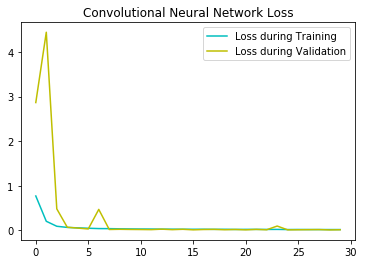

In [28]:
plt.figure()
plt.plot(eps, tl, 'c', label='Loss during Training')
plt.plot(eps, vl, 'y', label='Loss during Validation')

plt.title('Convolutional Neural Network Loss')

plt.legend()
plt.show()

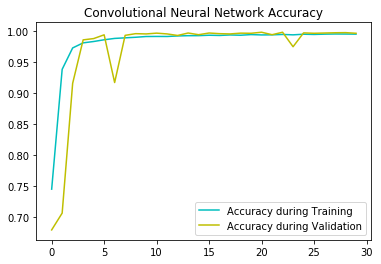

In [29]:
plt.title('Convolutional Neural Network Accuracy')
plt.plot(eps, ta, 'c', label='Accuracy during Training')
plt.plot(eps, va, 'y', label='Accuracy during Validation')

plt.legend()

plt.show()